# Sign Language MNIST

De [Sign Language MINST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) dataset is een dataset gebaseerd op de [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. De dataset bestaat uit afbeeldingen van American Sign Language. Er is hierbij 27,455 trainingsdata en 7172 testdata. De afbeeldingen zijn net als bij de Fashion MNIST per pixel in een 28 bij 28 matrix.

Voor de eindopdracht gaan we bezig met deze dataset met behulp het Keras-model en Tensorflow. Ook gebruiken we sklearn voor het maken van een meerdere classificatie rapporten.

## De dataset

Door Keras wordt de dataset aangeleverd als een csv bestand. Deze kunnen we inlezen met de pandas library. We gebruiken hierbij de `read_csv` functie. Ook isoleren we de labels makkelijk omdat deze als eerste kolom in de dataset staan. Ter controle printen we de shape van de data en de labels. Ook halen we snel de letters op die in die de `y` als waarde hebben.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

labels = [chr(i) for i in range(65, 91)]

dataset = pd.read_csv('sign_mnist_train.csv')
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values
print(f'X shape: {X.shape}\ny shape: {y.shape}')


X shape: (27455, 784)
y shape: (27455,)


Om deze data te kunnen gebruiken met Keras Sequential model moeten we de data scalen dat alles tussen 0 en 1 komt. Daarnaast moeten we de data ook nog eens reshapen zodat het in een 28 bij 28 matrix past. Om te controleren of dit goed is gegaan printen we nogmaals de shape van de data en de labels.

In [2]:
X = X / np.max(X)
X = X.reshape(X.shape[0], 28, 28)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (27455, 28, 28)
y shape: (27455,)


## De testdata

Idem als bij de trainingsdata.

In [3]:
from random import randint
test_dataset = pd.read_csv('sign_mnist_test.csv')
test_images = test_dataset.iloc[:, 1:].values
test_images = np.reshape(test_images, (test_images.shape[0], 28, 28))
test_labels = test_dataset.iloc[:, 0].values


## Het model

Nu we de data hebben kunnen we het model gaan maken. We gebruiken hierbij een Keran Sequential model. Keras hebben we al eerder mee gewerkt in Deel 3, waar we ook image classification hebben gedaan. 

Eerst maken we een standaard model, een nulmeting zeg maar, zoals we in `exercise3.py` hebben gedaan. De enige aanpassing is dat dee derde layer 25 input nodes krijgt in plaats van 10. Dit omdat we 26 verschillende gebaren hebben.

In [4]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(25, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X, y, epochs=10, use_multiprocessing=True)

Epoch 1/10
858/858 [==============================] - 2s 1ms/step - loss: 2.0701 - sparse_categorical_accuracy: 0.4030
Epoch 2/10
858/858 [==============================] - 1s 1ms/step - loss: 1.2099 - sparse_categorical_accuracy: 0.6371
Epoch 3/10
858/858 [==============================] - 1s 1ms/step - loss: 0.9137 - sparse_categorical_accuracy: 0.7264
Epoch 4/10
858/858 [==============================] - 1s 1ms/step - loss: 0.7269 - sparse_categorical_accuracy: 0.7868
Epoch 5/10
858/858 [==============================] - 1s 1ms/step - loss: 0.5981 - sparse_categorical_accuracy: 0.8278
Epoch 6/10
858/858 [==============================] - 1s 1ms/step - loss: 0.4958 - sparse_categorical_accuracy: 0.8591
Epoch 7/10
858/858 [==============================] - 1s 1ms/step - loss: 0.4022 - sparse_categorical_accuracy: 0.8884
Epoch 8/10
858/858 [==============================] - 1s 1ms/step - loss: 0.3398 - sparse_categorical_accuracy: 0.9087
Epoch 9/10
858/858 [============================

Laten we een willekeurige afbeelding uit de dataset pakken en kijken of het model het goed doet.

1/1 [==============================] - 0s 51ms/step
Actual label: U
Predicted label: V
Confidence: 38.0%
Confidence of actual label: 0.66%


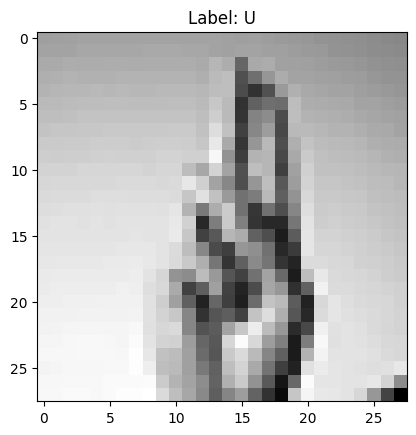

In [5]:
def random_test(model):
    choice = randint(0, test_images.shape[0])
    chosen_image = test_images[choice]
    chosen_image = chosen_image / np.max(chosen_image)
    chosen_image = chosen_image.reshape(1, 28, 28)

    plt.imshow(test_images[choice], cmap='gray')
    plt.title(f'Label: {labels[test_labels[choice]]}')

    predicted = model.predict(chosen_image)
    print(f'Actual label: {labels[test_labels[choice]]}')
    print(f'Predicted label: {labels[np.argmax(predicted)]}')
    print(f'Confidence: {round(np.max(predicted) * 100, 2)}%')

    if labels[test_labels[choice]] != labels[np.argmax(predicted)]:
        print(f"Confidence of actual label: {round(predicted[0][test_labels[choice]] * 100, 2)}%")

    plt.show()

random_test(model)

Na het meerdere keren aanpassen van de `epochs` in het model en daarna een maar keer een willekeurige afbeelding te pakken zien we dat het model over het algemeen goed werkt, maar in bepaalde gevallen een verkeerde voorspelling maakt. Als we de epoch hoger zetten, bijvoorbeeld van 8 naar 100, blijft dit gedrag voorkomen maar krijgt het model in geval van een verkeerde voorspelling een veel lagere confidence is het juiste antwoord. Dit willen we natuurlijk niet, dus gaan we later kijken of we dit kunnen verbeteren.

## Het model evalueren

Om het even kort samen te vatten, laten we een confusion matrix maken.

225/225 [==============================] - 0s 860us/step


<Figure size 640x480 with 0 Axes>

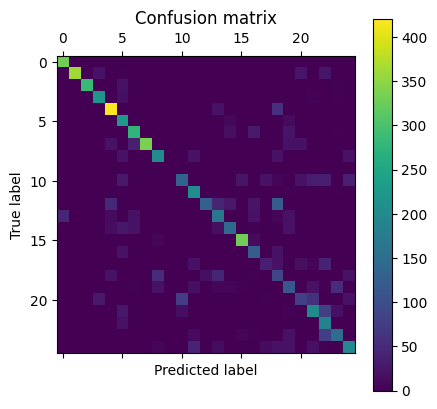

In [6]:
def conf_matrix(labels, pred):
    return tf.math.confusion_matrix(labels, pred)

pred = np.argmax(model.predict(test_images), axis=1)
conf_mtx = conf_matrix(test_labels, pred)

def plot_matrix(data):
    plt.figure()
    plt.matshow(data)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

plot_matrix(conf_mtx)

Deze confusion matrix laat zien dat het model het over het algemeen goed doet, maar in sommige gevallen een verkeerde voorspelling maakt.

# De dataset, de testdata en het model, mark 2

Tijdens het werken aan deze dataset kwamen we na een week hard werken achter dat het gebruik maken van integers als labels het berekenen van metrics zoals `tpr` en `fpr` onmogelijk maakt. Om dit op te lossen hebben we de labels omgezet naar one-hot encoding.

### One hot encoding

Bij het compileren van het model heb je de keuze om je labels op twee manieren te gebruiken. Je kan ze gebruiken als integers, zoals we eerder hebben gedaan, of je kan ze gebruiken als one-hot encoding. Bij one-hot encoding wordt er een array gemaakt met de lengte van het aantal labels. In deze array staat een 1 op de plek van het label en 0 op alle andere plekken. Bijvoorbeeld: `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]` voor het label 9.

**Label encoding**

| Letter | Nummer | Aantal |
|--------|--------|--------|
| A      | 0      | 2      |
| B      | 1      | 4      |
| C      | 2      | 6      |

**One-hot encoding**

| A | B | C | Aantal |
|---|---|---|--------|
| 1 | 0 | 0 | 2      |
| 0 | 1 | 0 | 4      |
| 0 | 0 | 1 | 6      |




Om meer inzicht te krijgen in de data moeten we dus onze labels omzetten naar een one-hot vector. Dit doen we met de `to_categorical` functie van Keras. Deze functie zet de labels om naar een one-hot vector. Dit is een vector met alleen maar nullen en een enkele 1. De positie van de 1 geeft aan welk label het is. Bijvoorbeeld: `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]` is een 9. [Deze notebook van een slimme GitHub gebruiker](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-sparse-categorical-crossentropy-in-keras.md) heeft ons geholpen met het omzetten van de labels.

In [7]:
print(f"X shape: {X.shape}\ny shape: {y.shape}")
y = keras.utils.to_categorical(y, 25)
print(f"X shape: {X.shape}\ny shape: {y.shape}")
test_labels = keras.utils.to_categorical(test_labels, 25)

print(f"Test images shape: {test_images.shape}\nTest labels shape: {test_labels.shape}")

X shape: (27455, 28, 28)
y shape: (27455,)
X shape: (27455, 28, 28)
y shape: (27455, 25)
Test images shape: (7172, 28, 28)
Test labels shape: (7172, 25)


Nu kunnen we ons model opnieuw bouwen, maar dan met de one-hot vector labels. Daaarnaast gaan we ook `CatagoricalCrossentropy` gebruiken als loss functie. Dit is een loss functie die one-hot vectoren gebruikt. Nu kunnen we meerdere metrics gebruiken, zoals `AUC`, `Precision` en `Recall`. Deze metrics kunnen ons goed helpen bij het verbeteren van het model omdat we nu kunnen zien hoe goed het model het doet in meer detail dan alleen de accuracy.

In [8]:
from keras.metrics import AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(25, activation='softmax')
])

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', AUC(), Precision(), Recall(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])

model.fit(X, y, epochs=10, use_multiprocessing=True, verbose=0)

De volgende metrics zijn nu beschikbaar:

In [9]:
loss = model.metrics[0].result()
acc = model.metrics[1].result()
auc = model.metrics[2].result()
prec = model.metrics[3].result()
rec = model.metrics[4].result()
tp = model.metrics[5].result()
tn = model.metrics[6].result()
fp = model.metrics[7].result()
fn = model.metrics[8].result()

print(f'Loss: {loss}\nAccuracy: {acc}\nAUC: {auc}\nPrecision: {prec}\nRecall: {rec}\nTrue positives: {tp}\nTrue negatives: {tn}\nFalse positives: {fp}\nFalse negatives: {fn}')

Loss: 0.2421606481075287
Accuracy: 0.9411400556564331
AUC: 0.9992150068283081
Precision: 0.9697895646095276
Recall: 0.9014751315116882
True positives: 24750.0
True negatives: 658149.0
False positives: 771.0
False negatives: 2705.0


## Het model evalueren, mark 2 (De ROC-curve)

Een ROC curve is een grafiek die de `tpr` en `fpr` van een model laat zien. `tpr` staat voor true positive rate en `fpr` staat voor false positive rate. De `tpr` is de ratio van de positieve voorspellingen die correct zijn. De `fpr` is de ratio van de negatieve voorspellingen die incorrect zijn. De ROC curve is een goede manier om te zien hoe goed een model het doet. Als de curve dichter bij de linkerbovenhoek zit, is het model beter. Als de curve dichter bij de diagonaal zit, is het model slechter. Als de curve onder de diagonaal zit, is het model slechter dan een random model.

Wat het meest interessant is aan een ROC-curve is de AUC. Dit staat voor Area Under Curve, oftewel het oppervlak onder de curve. Dit vat de curve samen in een enkel getal. Hoe hoger dit getal, hoe beter het model het doet. Een AUC van 1 betekent dat het model perfect is. Een AUC van 0.5 betekent dat het model net zo goed is als een random model. De AUC hier is al gegeven door keras.metrics.AUC, maar we plotten de curve ook om een beter beeld te krijgen van hoe goed het model het doet.

We gebruiken sklearn om de ROC curve te plotten in een subplot.


C:\Users\Ems\AppData\Local\Temp\ipykernel_31704\3620659491.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


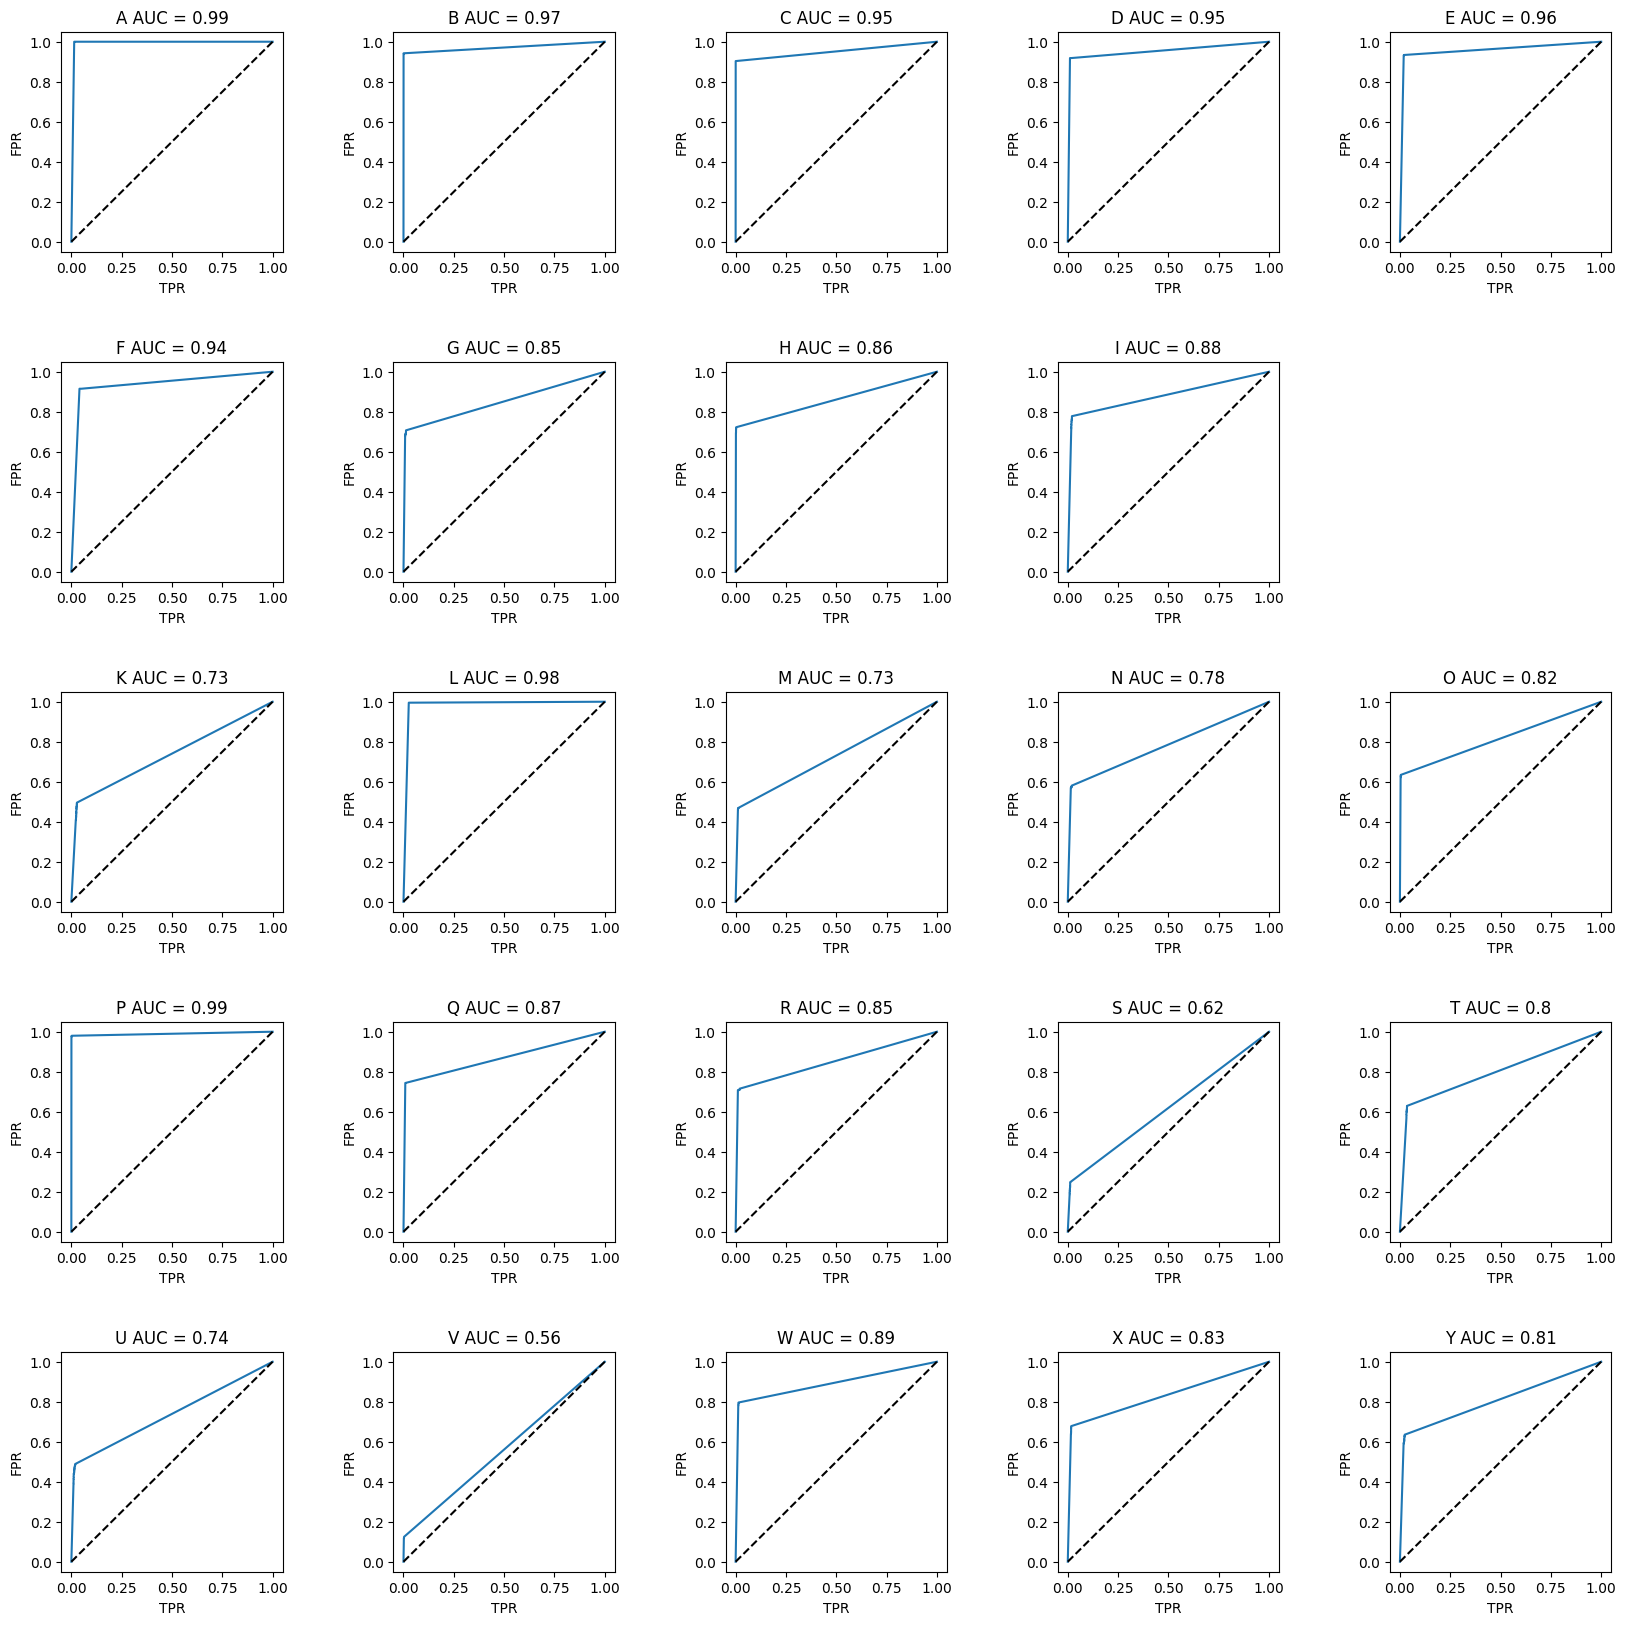

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_rocs_per_letter(labels, model):
    """
    Plots ROC curves for each letter in the alphabet for the given model.
    Adds the AUC score to the title of each plot.
    """
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    preds = model.predict(test_images, verbose=0)
    for i in range(25):
        plot = ax[i // 5, i % 5]
        if i == 9:
            plot.axis('off')
            continue
        tpr, fpr, _ = roc_curve(test_labels[:, i], preds[:, i])
        plot.plot(tpr, fpr)
        plot.plot([0, 1], [0, 1], linestyle='--', color='black')
        plot.set_title(f'{labels[i]} AUC = {round(roc_auc_score(test_labels[:, i], preds[:, i]), 2)}')
        plot.set_xlabel('TPR')
        plot.set_ylabel('FPR')

    fig.show()

plot_rocs_per_letter(labels, model)

## Het model evalueren, mark 2 (De Precision-Recall curve)

Ook een mooie grafiek om te gebruiken met het trainen van ML-modellen is de Precision-Recall curve. Deze curve laat de precision en recall zien van een model.

![Precision-Recall curve](./assets/Precisionrecall.png)

De precision is gedefineerd als de ratio van de positieve voorspellingen die relevant zijn. Dit is berekend met de volgende formule:
$$
\begin{align}
  \text{Precision} &= \frac{tp}{tp + fp}
\end{align}
$$

De recall, ook wel sensitivity genoemd, is gedefineerd als de ratio van de positieve voorspellingen die correct zijn. Dit is berekend met de volgende formule:
$$
\begin{align}
  \text{Recall} &= \frac{tp}{tp + fn}
\end{align}
$$

Een model kan beide kanten op gaan. Het kan een hoge precision hebben, maar een lage recall. Dit betekent dat het model weinig false positives heeft, maar wel veel false negatives. Het kan ook een lage precision hebben, maar een hoge recall. Dit betekent dat het model veel false positives heeft, maar weinig false negatives. 

Per model kan het verschillen wat belangrijker is. Als je bijvoorbeeld een model hebt dat kanker moet detecteren, is het belangrijk dat het model een hoge recall heeft. Het is dan niet erg als het model veel false positives heeft, zolang het maar geen false negatives heeft. Als je een model hebt dat moet voorspellen of een e-mail spam is, is het belangrijk dat het model een hoge precision heeft. Het is dan niet erg als het model veel false negatives heeft, zolang het maar geen false positives heeft.

Deze twee worden samen geplot in een Precision-Recall curve. De precision wordt geplot op de x-as en de recall wordt geplot op de y-as. De curve is een lijn die de precision en recall van het model laat zien. De curve begint linksboven en eindigt rechtsonder. Een model met een hoge precision en recall heeft een curve die dichter bij de linkerbovenhoek zit. Een model met een lage precision en recall heeft een curve die dichter bij de rechteronderhoek zit. Een model met een hoge precision en lage recall heeft een curve die dichter bij de linkerbenedenhoek zit. Een model met een lage precision en hoge recall heeft een curve die dichter bij de rechterbovenhoek zit.

C:\Users\Ems\AppData\Local\Temp\ipykernel_31704\1100965165.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


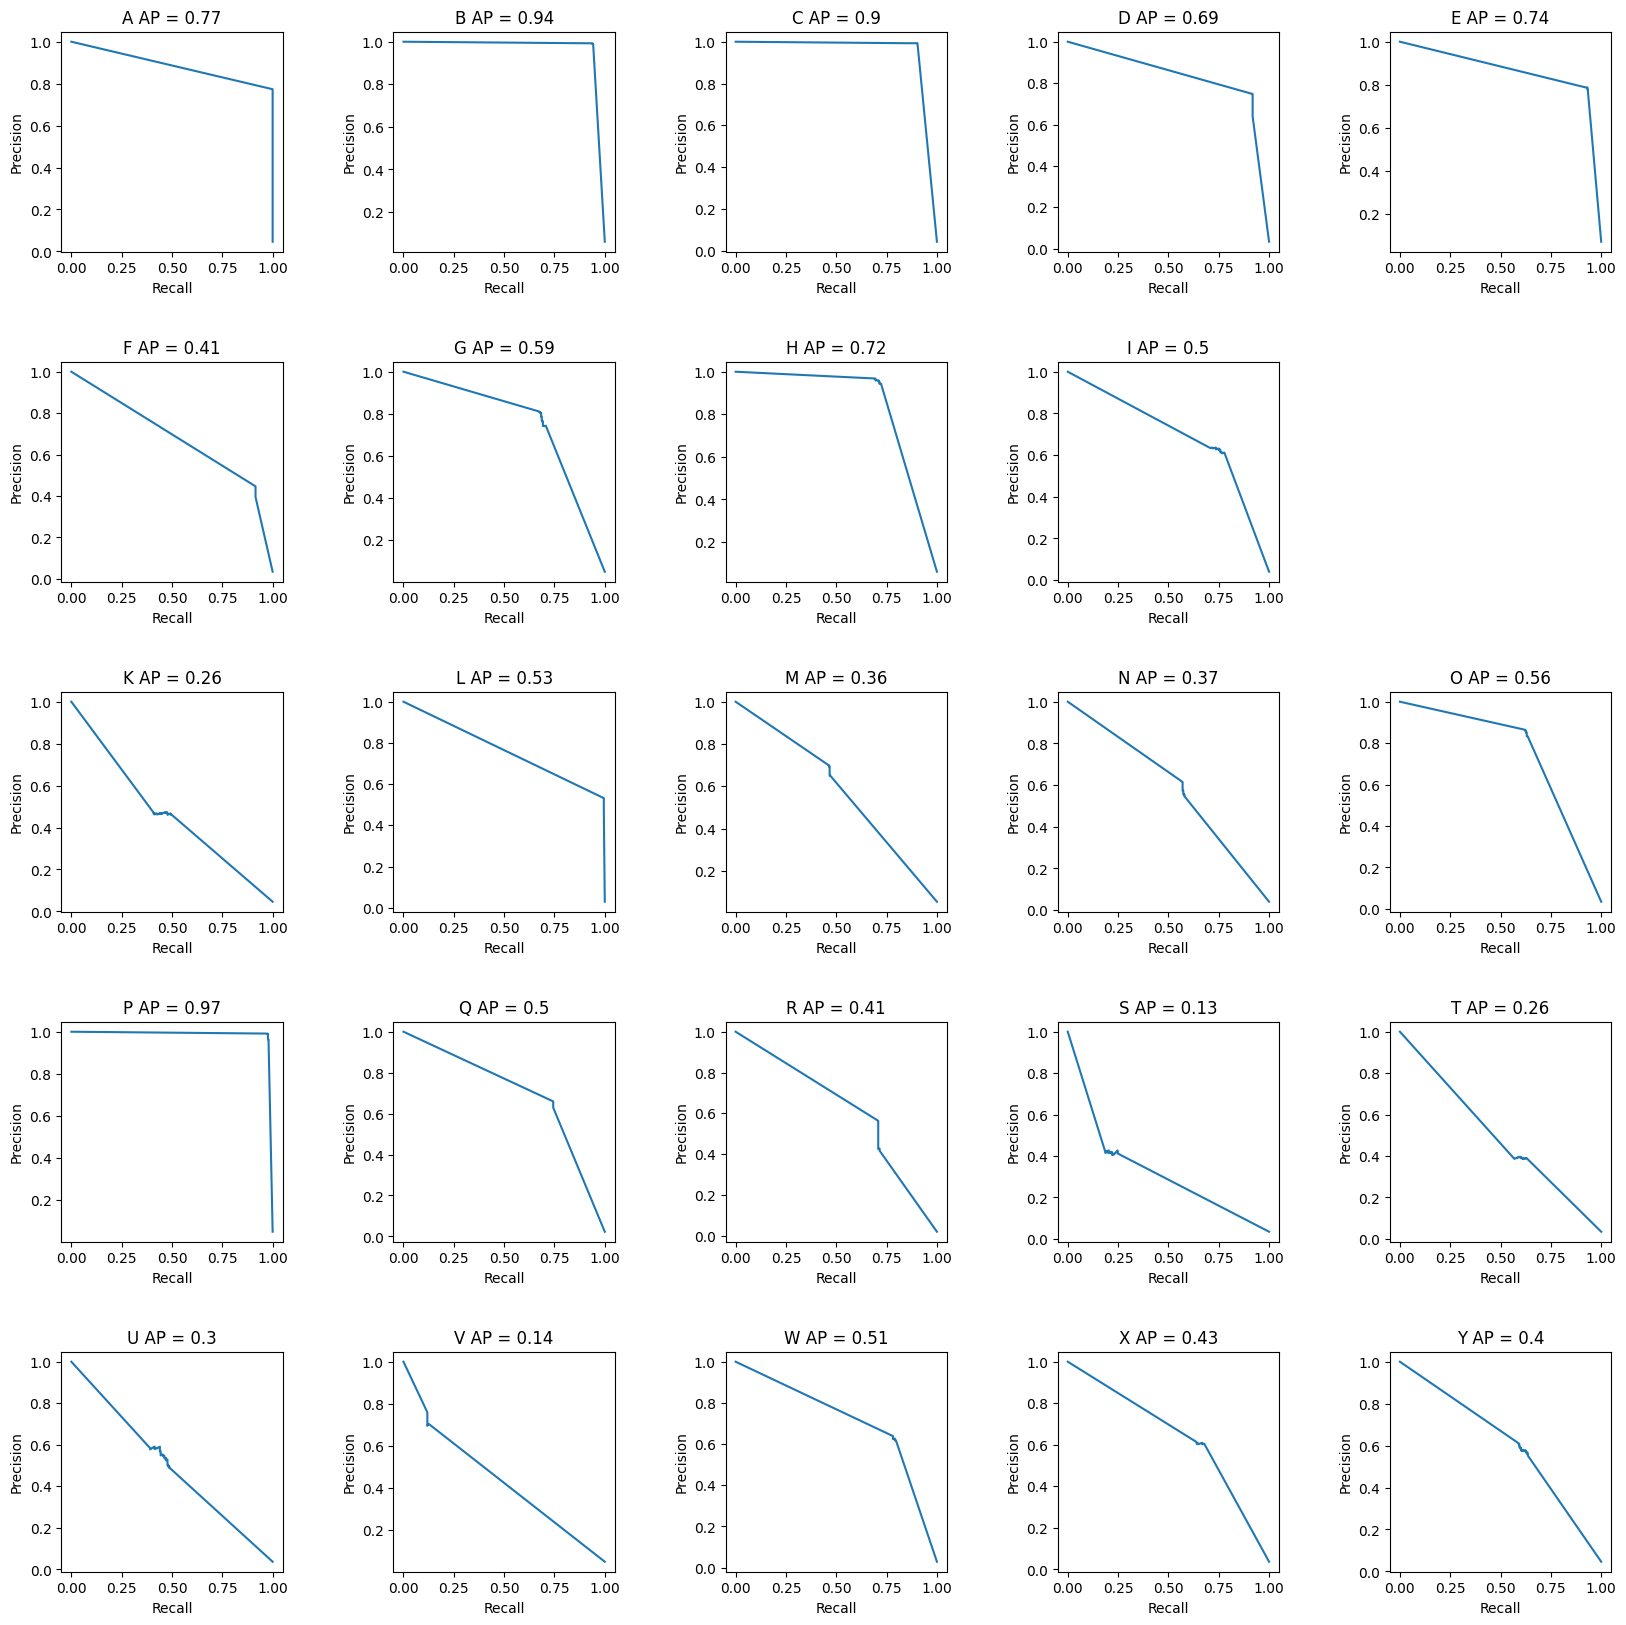

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_prs_per_letter(labels, model):
    """
    Plots precision-recall curves for each letter in the alphabet for the given model.
    Adds the average precision score to the title of each plot.
    """
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    preds = model.predict(test_images, verbose=0)
    for i in range(25):
        plot = ax[i // 5, i % 5]
        if i == 9:
            plot.axis('off')
            continue
        prec, rec, _ = precision_recall_curve(test_labels[:, i], preds[:, i])
        plot.plot(rec, prec)
        plot.set_title(f'{labels[i]} AP = {round(average_precision_score(test_labels[:, i], preds[:, i]), 2)}')
        plot.set_xlabel('Recall')
        plot.set_ylabel('Precision')

    fig.show()

plot_prs_per_letter(labels, model)

## De conclusie van het model

We hebben nu een **Confusion Matrix**, **ROC-curve** en een **Precision-Recall curve**. Deze geven ons een goed beeld van hoe goed het model het doet. We zien dat vooral  bij M, S en U het model vaak de mist in gaat. Dit is te zien in alle grafieken en ook als we een willekeurig plaatje aanroepen gaan die bij deze vaak een andere letter aanwijzen.

TODO: Conclusie schrijven

## Verbetering van het model

Nu kunnen we verder gaan met het verbeteren van het model. We gaan dit doen door het model aan te passen en te kijken of de metrics verbeteren. We gaan beginnen door de `layers` aan te passen.

### Convolutional Neural Networks

Een Convolutional Neural Network (CNN) is een type neural network dat vaak gebruikt wordt voor image classification. Kort gezegd, waar onze simpele 'nulmeting' model met zijn blote handen een naald in een hooiberg moet zoeken, heeft dit model een vergootglas, namelijk de Conv2D layers. Deze kijkt naar de details in de data en kan deze opslaan. De MaxPooling2D layer zorgt ervoor dat de data kleiner wordt, zodat het model sneller kan leren. De Flatten layer zorgt ervoor dat de data weer in een 1D array komt, zodat het model het kan gebruiken.

We halen onze data twee keer door de CNN layers voor nu, om overfitting te verkomen (en de fit-tijd korter te maken!).



In [12]:
better_model = keras.Sequential(
    [
        keras.layers.Conv2D(64, 3, activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(25, activation='softmax')
    ]
)

better_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), Precision(), Recall(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])

better_model.fit(X, y, epochs=5, use_multiprocessing=True)

Epoch 1/5
858/858 [==============================] - 13s 14ms/step - loss: 0.7825 - accuracy: 0.7689 - auc_1: 0.9839 - precision_1: 0.9410 - recall_1: 0.6825 - true_positives_1: 18739.0000 - true_negatives_1: 657745.0000 - false_positives_1: 1175.0000 - false_negatives_1: 8716.0000
Epoch 2/5
858/858 [==============================] - 17s 19ms/step - loss: 0.0292 - accuracy: 0.9953 - auc_1: 1.0000 - precision_1: 0.9961 - recall_1: 0.9936 - true_positives_1: 27278.0000 - true_negatives_1: 658812.0000 - false_positives_1: 108.0000 - false_negatives_1: 177.0000
Epoch 3/5
858/858 [==============================] - 12s 14ms/step - loss: 0.0070 - accuracy: 0.9989 - auc_1: 1.0000 - precision_1: 0.9989 - recall_1: 0.9989 - true_positives_1: 27424.0000 - true_negatives_1: 658891.0000 - false_positives_1: 29.0000 - false_negatives_1: 31.0000
Epoch 4/5
858/858 [==============================] - 12s 14ms/step - loss: 8.4598e-04 - accuracy: 1.0000 - auc_1: 1.0000 - precision_1: 1.0000 - recall_1: 1.

## Het (betere?) model evalueren

Aangezien onze eerste implementaties van de willekeurige afbeelding en de confusion matrix waren gebaseerd op de niet one-hot encoded labels, moeten we deze opnieuw maken.

True label: H
Predicted label: H
Confidence: 99.12%


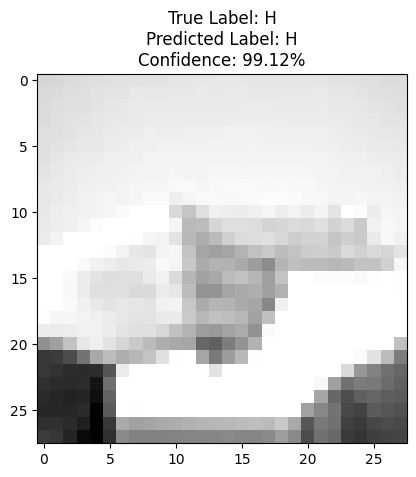

In [13]:
def random_test_oh(model):
    choice = randint(0, test_images.shape[0])
    chosen_image = test_images[choice]
    chosen_image = chosen_image / np.max(chosen_image)
    chosen_image = chosen_image.reshape(1, 28, 28)

    plt.imshow(test_images[choice], cmap='gray')
    true_label = labels[np.argmax(test_labels[choice])]  # Convert one-hot label to label index

    predicted = model.predict(chosen_image, verbose=0)
    predicted_label = labels[np.argmax(predicted)]

    print(f'True label: {true_label}')
    print(f'Predicted label: {predicted_label}')

    confidence = round(np.max(predicted) * 100, 2)
    print(f'Confidence: {confidence}%')

    if true_label != predicted_label:
        true_confidence = round(predicted[0][np.argmax(test_labels[choice])] * 100, 2)
        print(f"Confidence of true label: {true_confidence}%")

    plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}\nConfidence: {confidence}%')
    plt.show()

random_test_oh(better_model)


<Figure size 640x480 with 0 Axes>

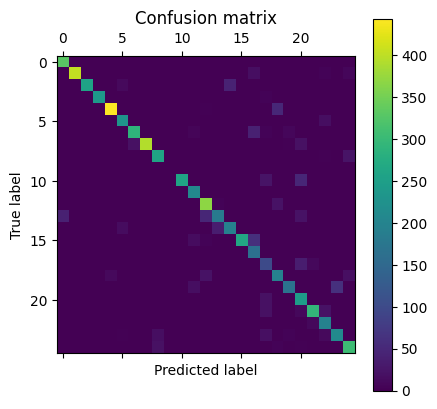

C:\Users\Ems\AppData\Local\Temp\ipykernel_31704\3620659491.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Ems\AppData\Local\Temp\ipykernel_31704\1100965165.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


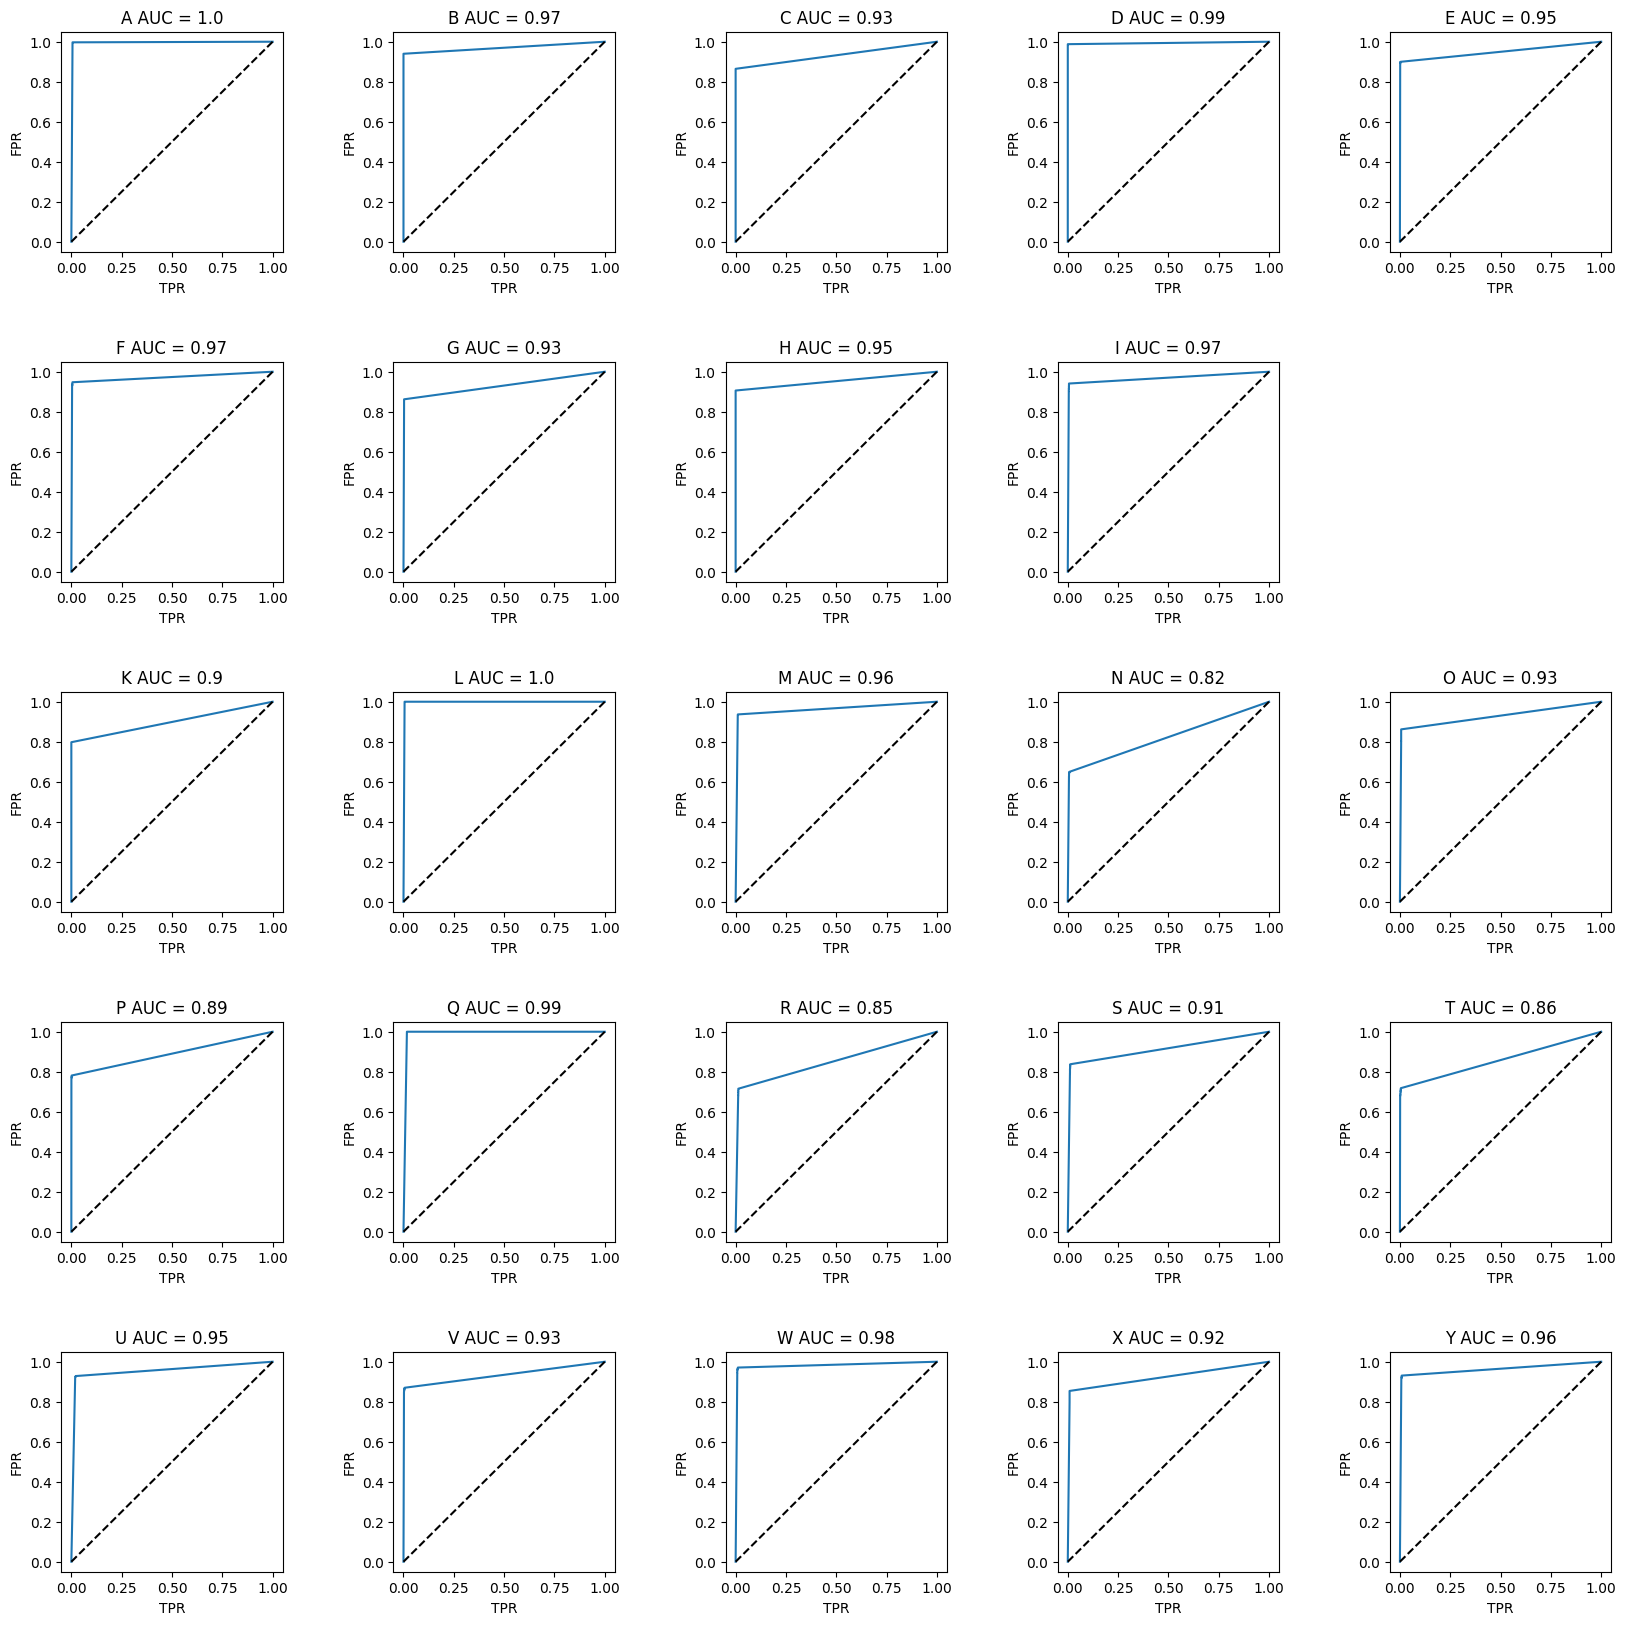

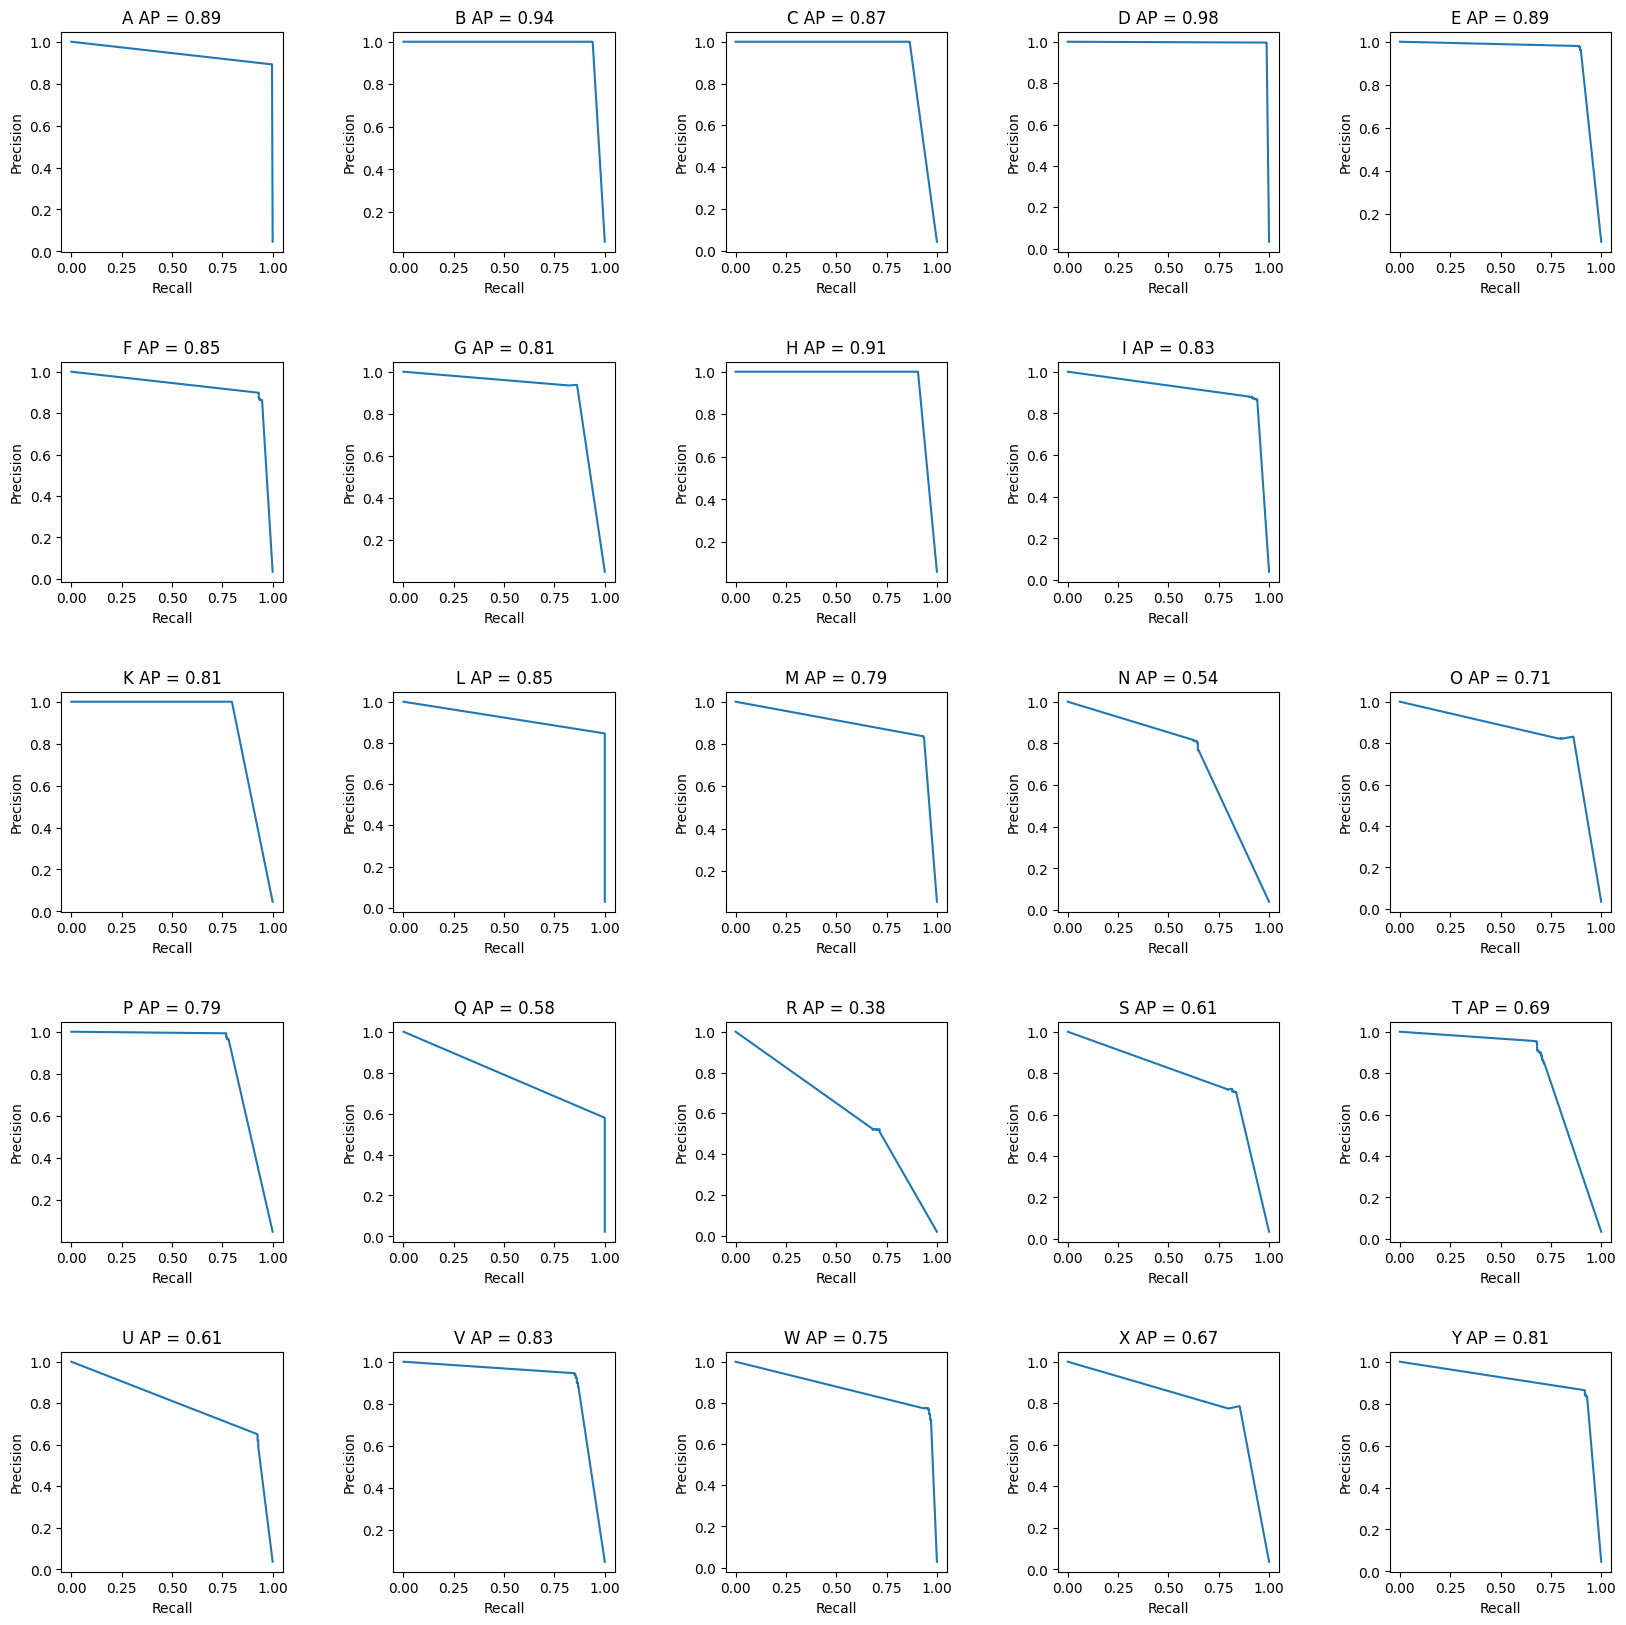

In [14]:
def conf_mtx_oh(model):
    pred = np.argmax(model.predict(test_images, verbose = 0), axis=1)

    labels = np.array([np.argmax(label) for label in test_labels])

    conf_mtx = tf.math.confusion_matrix(labels, pred)
    plt.figure()
    plt.matshow(conf_mtx)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

def plot_all_stats(model):
    conf_mtx_oh(model)
    plot_rocs_per_letter(labels, model)
    plot_prs_per_letter(labels, model)


plot_all_stats(better_model)

In dit verbeterde model zien we dat de performance een stuk beter is. Hij maakt nog steeds fouten, maar in veel mindere mate.

## Nog meer modellen

Nu gaan we nog wat meer modellen uitproberen en dan kijken of we `better_model` kunnen verslaan!

### Carl 🐢

Carl is ook een CNN model, maar hij maakt gebruik van `Dropout` layers. `Dropout` layers zorgen ervoor dat een bepaald percentage van de nodes in een layer worden uitgeschakeld. Dit zorgt ervoor dat het model niet overfit. We gaan Carl twee keer door de CNN layers halen, net als bij `better_model`. en daarna gaan we hem door de `Dropout` layer halen. 

Zoals je ziet wordt er ook gebruik gemaakt van `kernel_size`, `pool_size` en `strides`. Deze limiteren

In [15]:
carl = keras.Sequential(
    [
        keras.layers.Input(shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(25, activation='softmax')
    ]
)

carl.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), Precision(), Recall(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])

carl.fit(X, y, epochs=5, use_multiprocessing=True)

carl.summary()

Epoch 1/5
858/858 [==============================] - 8s 8ms/step - loss: 1.3155 - accuracy: 0.6055 - auc_2: 0.9557 - precision_2: 0.8659 - recall_2: 0.4500 - true_positives_2: 12356.0000 - true_negatives_2: 657006.0000 - false_positives_2: 1914.0000 - false_negatives_2: 15099.0000
Epoch 2/5
858/858 [==============================] - 7s 8ms/step - loss: 0.3310 - accuracy: 0.8921 - auc_2: 0.9974 - precision_2: 0.9313 - recall_2: 0.8526 - true_positives_2: 23407.0000 - true_negatives_2: 657193.0000 - false_positives_2: 1727.0000 - false_negatives_2: 4048.0000
Epoch 3/5
858/858 [==============================] - 7s 8ms/step - loss: 0.1621 - accuracy: 0.9485 - auc_2: 0.9994 - precision_2: 0.9614 - recall_2: 0.9331 - true_positives_2: 25619.0000 - true_negatives_2: 657891.0000 - false_positives_2: 1029.0000 - false_negatives_2: 1836.0000
Epoch 4/5
858/858 [==============================] - 7s 8ms/step - loss: 0.1064 - accuracy: 0.9668 - auc_2: 0.9996 - precision_2: 0.9729 - recall_2: 0.9594 

Laten we een ROC curve maken waar alle modellen in staan. Dit doen we door de `predict` functie van elk model te gebruiken en dan de `roc_curve` functie van sklearn te gebruiken. We plotten de ROC curve van elk model in een subplot.

C:\Users\Ems\AppData\Local\Temp\ipykernel_31704\1922818938.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


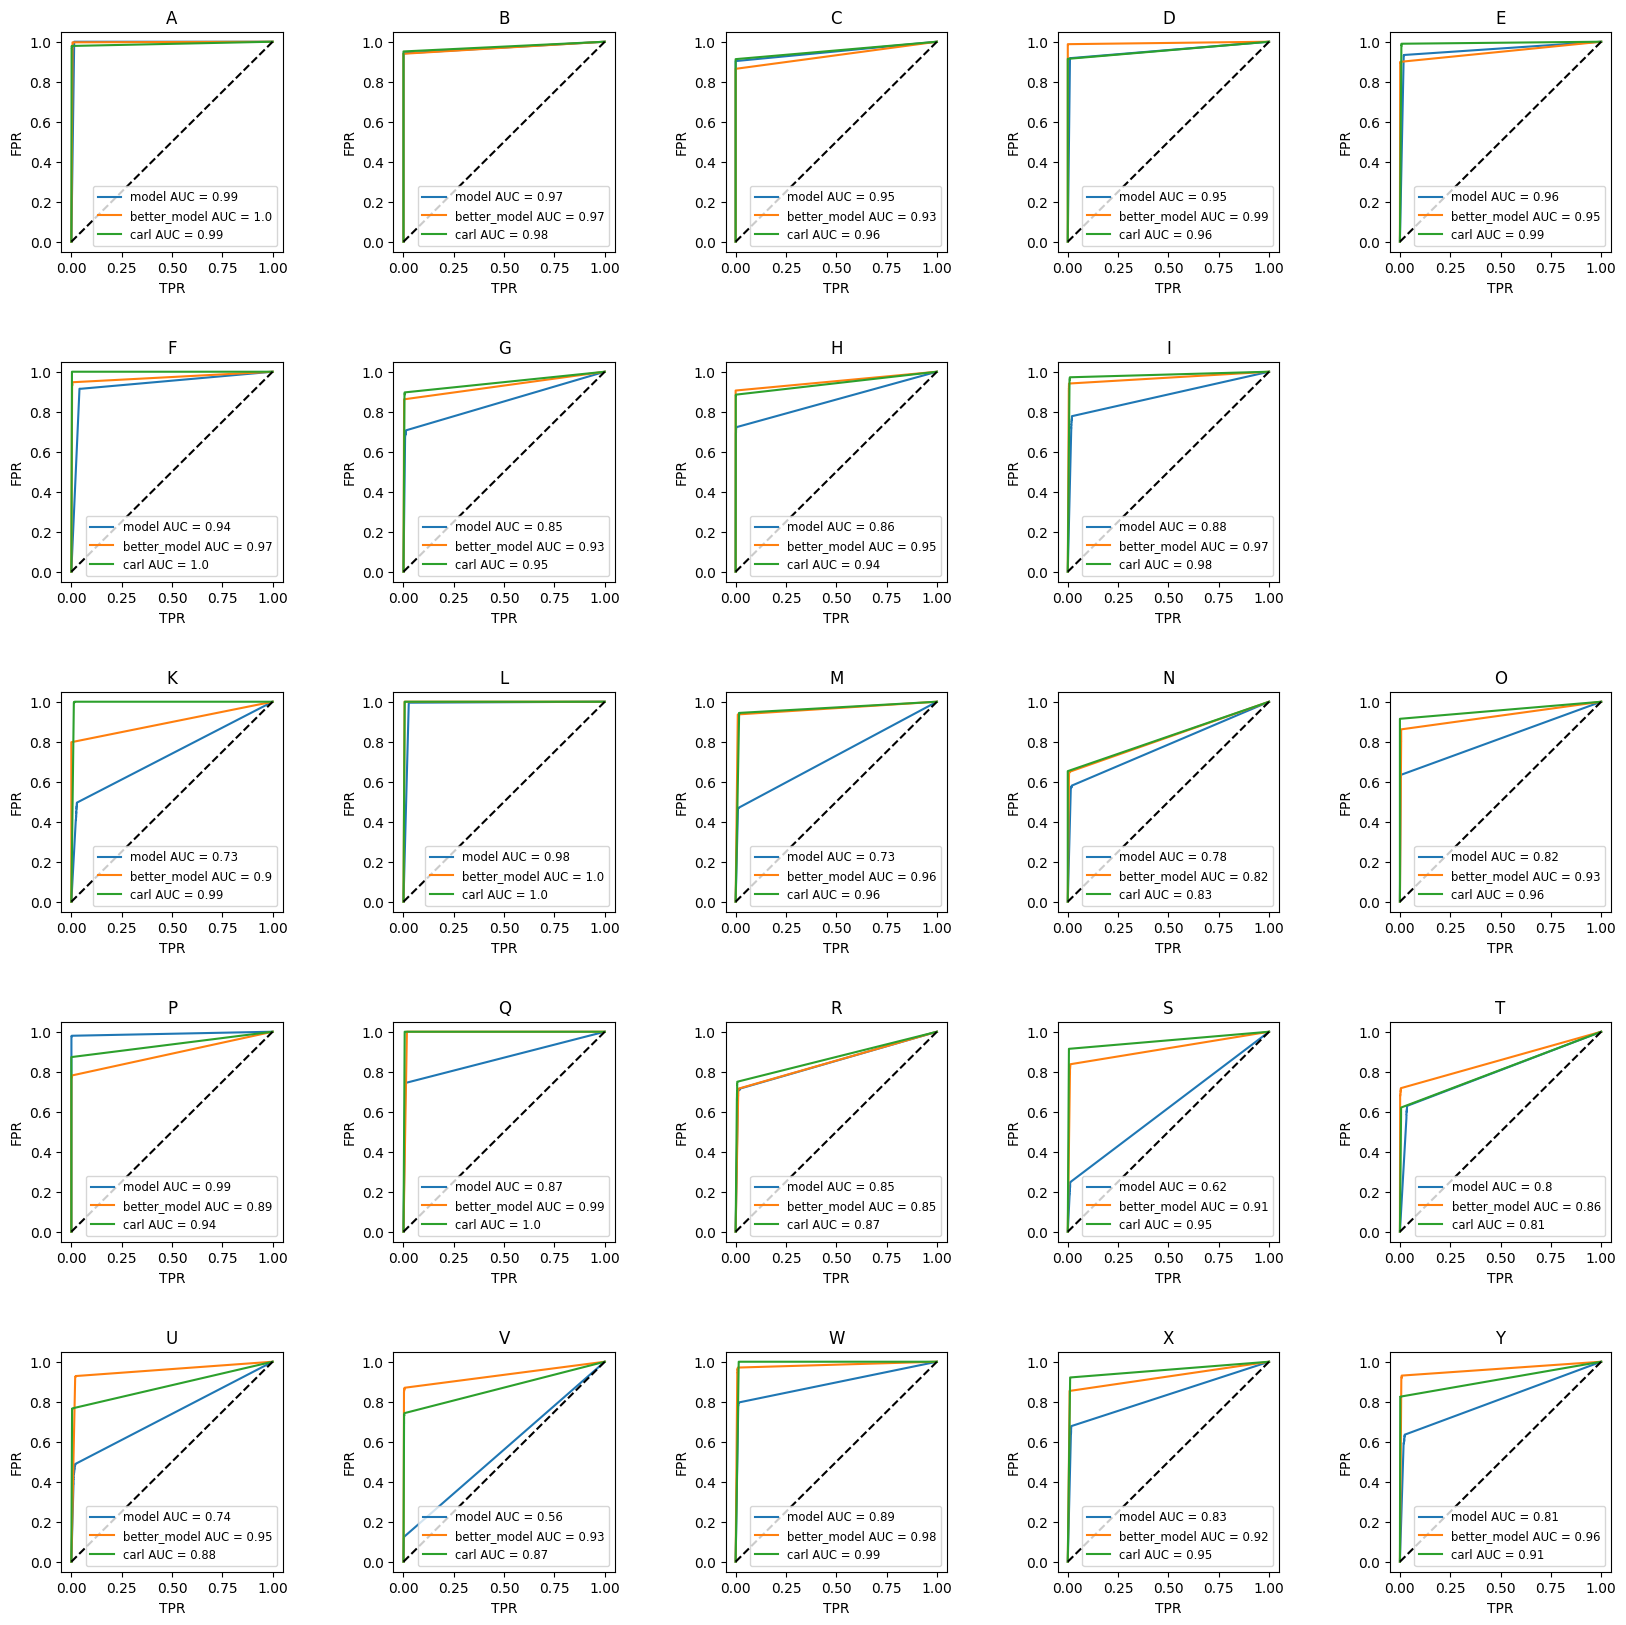

In [16]:
def roc_analysis(**models):
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    preds = [model.predict(test_images, verbose=0) for model in models.values()]
    for i in range(25):
        plot = ax[i // 5, i % 5]
        if i == 9:
            plot.axis('off')
            continue
        for j, pred in enumerate(preds):
            tpr, fpr, _ = roc_curve(test_labels[:, i], pred[:, i])
            plot.plot(tpr, fpr, label=f'{list(models.keys())[j]} AUC = {round(roc_auc_score(test_labels[:, i], pred[:, i]), 2)}')
        plot.plot([0, 1], [0, 1], linestyle='--', color='black')
        plot.set_title(f'{labels[i]}')
        plot.set_xlabel('TPR')
        plot.set_ylabel('FPR')
        plot.legend(loc='lower right', fontsize='small')

    fig.show()

roc_analysis(model=model, better_model=better_model, carl=carl)